In [53]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns 
import scipy.stats as stats 
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype
from IPython.display import display
from adjustText import adjust_text
from tqdm import tqdm

In [20]:
#### SNPs annotations
snps_loc = pd.read_csv('../../data/genotype_information/snps_annotations_genome-version-3-64-1.txt').rename(columns={'snp_id':'SNP'})
snps_loc['SNP'] = snps_loc['SNP'].astype(int)
snps_loc['SNP_ID'] = [ f'{snps_loc["chrom"][idx].replace("_","")}_{snps_loc["SNP"][idx]}' for idx in snps_loc.index]
snps_loc['position'] = snps_loc['position'].astype(int)

#### Gene names 

gene_loc = pd.read_csv('../../data/genotype_information/yeast_ORFs_dec2022.txt')

#### Genotype matrix
genotype = pd.read_csv('../../data/genotype_information/piQTL_genotype_matrix_dec2022.txt')
nb_strains = len(genotype.columns) - 1

In [22]:
def get_chr(x, gene_loc):
    try : 
        return gene_loc[gene_loc['name'] == x]['chrom'].values[0].replace('CHR', '')
    except : 
        return np.nan

PPI_list = pd.read_csv('../../data/pipeline/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

PPI_list['CHR_bait'] = PPI_list['PPI_bait'].apply(get_chr, args=(gene_loc,))
PPI_list['CHR_prey'] = PPI_list['PPI_prey'].apply(get_chr, args=(gene_loc,))

In [4]:
for gene in set(np.unique(PPI_list['PPI_bait'].values)) | set(np.unique(PPI_list['PPI_prey'].values)):
    print(gene)

PGM2
PIS1
ERG11
SRO9
VAC8
ORM2
PLM2
HYR1
SNA4
TCB2
PIN2
HNM1
MID2
EMP70
RSN1
LSM3
UIP4
RBD2
PMC1
noPPI
SGN1
ALO1
CTR2
RET2
MEP1
SLM4
TPO4
SSH1
ACF2
FMP45
GTR2
MAM33
SNA3
WSC2
TPO1
DHH1
ERV25
ERG5
TPO2
EMP47
ADE17
ERG27
reference
HUG1
GTR1
GIS2


#### Merge all results (MTX + Drug) from rMVP

In [5]:
def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    effect = table['Effect'][idx]
    if z_score >= 3 :
        if effect > 0 :
            return 1 
        elif effect < 0 :
            return -1 
    else :
        return 0

In [6]:
folder_path = '../../results/04a_rMVP/rMVP_outputs/piQTL_dec_2022_annotated'
all_MTX = []
all_noMTX = []
ALL = []
MTX_correlation_matrix = []
noMTX_correlation_matrix = []
for PPI in tqdm(PPI_list['PPI']): 
    for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] : 
        # print(PPI) 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]
        # print(CHR_prey, CHR_bait)
        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX = MTX.rename(columns={f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.GLM':'p-value'})
        MTX['SNP_ID'] = [ f'CHR{MTX["Chr"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        # noMTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        # noMTX = noMTX.rename(columns={f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_minus_ref.GLM':'p-value'})
        # noMTX['SNP_ID'] = [ f'CHR{noMTX["Chr"][idx]}_{noMTX["SNP"][idx]}' for idx in noMTX.index ]
        
        MTX['-log_pval'] = -np.log10(MTX['p-value'])
        # MTX[f'{PPI}_MTX_{DRUG}'] = MTX['-log_pval'] >= 3
        # MTX[f'{PPI}_MTX_{DRUG}'] = MTX[f'{PPI}_MTX_{DRUG}'].astype(int)
        MTX['QTLs'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        MTX['Condition'] = f'{PPI}_MTX_{DRUG}'
        all_MTX.append(MTX)
        ALL.append(MTX)
        MTX_correlation_matrix.append(MTX[['SNP_ID', 'QTLs']].set_index('SNP_ID').T)
        
        # noMTX['-log_pval'] = -np.log10(noMTX['p-value'])
        # # noMTX[f'{PPI}_noMTX_{DRUG}'] = noMTX['-log_pval'] >= 3
        # # noMTX[f'{PPI}_noMTX_{DRUG}'] = noMTX[f'{PPI}_noMTX_{DRUG}'].astype(int)
        # noMTX['QTLs'] = [ set_correlation_score(idx, noMTX) for idx in noMTX.index ]
        # noMTX['Condition'] = f'{PPI}_noMTX_{DRUG}'
        # all_noMTX.append(noMTX)
        # ALL.append(noMTX)
        # noMTX_correlation_matrix.append(noMTX[['SNP_ID', 'QTLs']].set_index('SNP_ID').T)
    
MTX_DF = pd.concat(MTX_correlation_matrix) #.reset_index().rename(columns={'index':'Condition'})
# noMTX_DF = pd.concat(noMTX_correlation_matrix) #.reset_index().rename(columns={'index':'Condition'})


100%|██████████| 62/62 [04:48<00:00,  4.65s/it]


##### Keep hits that are significant in eQTL matrix

In [7]:
eQTL_t_res = pd.read_csv('../../results/04b_eQTL_matrix/piQTL_dec2022_pval_results.txt', sep='\t')
eQTL_anova_res = pd.read_csv('../../results/04b_eQTL_matrix/piQTL_dec2022_anova_pval_results.txt', sep='\t')

In [8]:
compare_models = eQTL_t_res.merge(eQTL_anova_res, on=['SNP', 'gene'], suffixes=['_linear_model', '_anova_model'])

In [9]:
stats.pearsonr(compare_models['p-value_linear_model'], compare_models['p-value_anova_model'])

(0.9131823481385273, 0.0)

In [10]:
eQTL_res = pd.read_csv('../../results/04b_eQTL_matrix/piQTL_dec2022_pval_results.txt', sep='\t')

In [11]:
def format_cdt(x):
    ppi_prey = x.split('_')[0]
    ppi_bait = x.split('_')[1]
    MTX_cdt = x.split('_')[2]
    DRUG = x.split('_')[3].replace('-','.')
    cdt = f'{ppi_prey}_{ppi_bait}_{MTX_cdt}_{DRUG}'
    return cdt

In [12]:
eQTL_res['Condition'] = eQTL_res['gene'].apply(format_cdt)
eQTL_MTX_RES = eQTL_res[eQTL_res['Condition'].str.contains('_MTX_')].reset_index(drop=True)
eQTL_SIGN_RES = eQTL_MTX_RES[eQTL_MTX_RES['p-value'] <= 0.001]

In [13]:
len(eQTL_SIGN_RES)

21154

In [14]:
eQTL_SIGN_RES[['SNP', 'Condition', 'beta', 't-stat', 'p-value', 'FDR']]

,SNP,Condition,beta,t-stat,p-value,FDR
0,10448,noPPI_reference_MTX_Metformin,-2.416725,-22.894170,6.807250e-72,5.087385e-65
1,10446,noPPI_reference_MTX_Metformin,-2.380192,-22.009003,2.549215e-68,6.350504e-62
2,10447,noPPI_reference_MTX_Metformin,-2.380192,-22.009003,2.549215e-68,6.350504e-62
3,10446,noPPI_reference_MTX_5.FC,-2.633171,-21.200356,4.908346e-65,7.336486e-59
4,10447,noPPI_reference_MTX_5.FC,-2.633171,-21.200356,4.908346e-65,7.336486e-59
...,...,...,...,...,...,...
21149,8890,HNM1_MAM33_MTX_Metformin,-0.414635,-3.318433,9.989923e-04,2.358835e-01
21150,5722,HNM1_ERG11_MTX_Fluconazole,-0.457595,-3.318393,9.991309e-04,2.359088e-01
21151,11896,HUG1_PGM2_MTX_noDrug,-0.577562,-3.318337,9.993267e-04,2.359476e-01
21152,10886,ERG11_ERV25_MTX_Metformin,0.349801,3.318201,9.997969e-04,2.360288e-01


##### Keep hits that are significant in rMVP

In [15]:
rMVP_MTX_RES = pd.concat(all_MTX)
rMVP_SIGN_RES = rMVP_MTX_RES[rMVP_MTX_RES['p-value'] <= 0.001]

In [16]:
len(rMVP_SIGN_RES)

22145

#### Keep overlapping between rMVP and eQTL matrix

In [ ]:
ALL_RES = eQTL_MTX_RES[['SNP', 'Condition', 'beta', 't-stat', 'p-value', 'FDR']].merge(rMVP_MTX_RES, on=['SNP', 'Condition'], suffixes=['_eQTL', '_rMVP'])
# ALL_RES.to_csv('../../results/05_piQTL_tables/all_piQTLs_results_with_genome_annotations_with_MTX_peaks.csv', index=False)

In [ ]:
len(ALL_RES)

In [ ]:
ALL_RES

In [ ]:
eQTL_vs_rMVP = eQTL_SIGN_RES[['SNP', 'Condition', 'beta', 't-stat', 'p-value', 'FDR']].merge(rMVP_SIGN_RES, on=['SNP', 'Condition'], suffixes=['_eQTL', '_rMVP'])

In [ ]:
len(np.unique(eQTL_vs_rMVP['SNP']))

In [ ]:
stats.pearsonr(eQTL_vs_rMVP['p-value_eQTL'], eQTL_vs_rMVP['p-value_rMVP'])

In [ ]:
eQTL_vs_rMVP.to_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_with_MTX_peaks.csv', index=False)

In [ ]:
len(eQTL_vs_rMVP)

In [ ]:
eQTL_vs_rMVP[eQTL_vs_rMVP['-log_pval'] > 3]

#### Identify noDrug-specific QTLs

In [ ]:
TO_REMOVE = eQTL_vs_rMVP[eQTL_vs_rMVP['Condition'].str.contains('noDrug')]['SNP'].values

In [ ]:
len(TO_REMOVE), len(np.unique(TO_REMOVE))

In [ ]:
all_QTLs = pd.read_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')

SIGN_RES = all_QTLs
SIGN_RES['PPI'] = [ f"{SIGN_RES['Condition'][idx].split('_')[0]}:{SIGN_RES['Condition'][idx].split('_')[1]}" for idx in SIGN_RES.index ] 
SIGN_RES['DRUG'] = [ f"{SIGN_RES['Condition'][idx].split('_')[3]}" for idx in SIGN_RES.index ] 
SIGN_RES['CDT'] = [ f"{SIGN_RES['Condition'][idx].split('_')[2]}:{SIGN_RES['Condition'][idx].split('_')[3]}" for idx in SIGN_RES.index ] 
 
for DRUG in ['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] : 
    print(DRUG)
    TMP = SIGN_RES[SIGN_RES['DRUG'] == DRUG].reset_index(drop=True)
    TMP = TMP[~TMP["SNP"].isin(np.unique(TO_REMOVE))]
    TMP = TMP[['PPI', 'DRUG', 'SNP', 'Chr', 'Pos', 'p-value_eQTL', 'p-value_rMVP', 'FDR', '-log_pval', 'name', 'sgd_id', 'locus_id', 'snps_class_up', 'snps_class_down', 'description']]
    print(len(TMP.reset_index(drop=True)))
    TMP.reset_index(drop=True).sort_values(['FDR', 'SNP', 'Chr', 'Pos',]).to_csv(f'../../results/05_piQTL_tables/remove_hits_from_noDrug/{DRUG}_piQTLs_without_hits_in_noDrug_cdt.csv', index=False)


Index(['SNP', 'Condition', 'beta', 't-stat', 'p-value_eQTL', 'FDR', 'Chr',
       'Pos', 'Effect', 'SE', 'p-value_rMVP', 'locus_id', 'name', 'sgd_id',
       'snps_class_up', 'snps_class_down', 'description', 'genome_annotations',
       'SNP_ID', '-log_pval', 'QTLs', 'PPI', 'DRUG', 'CDT'],
      dtype='object')


 50%|█████     | 2/4 [00:00<00:00, 11.84it/s]

5.FC
(2195, 13)
1342 853
Fluconazole
(4338, 13)
3861 477
Metformin
(2492, 13)
2072 420


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Trifluoperazine
(1954, 13)
1123 831


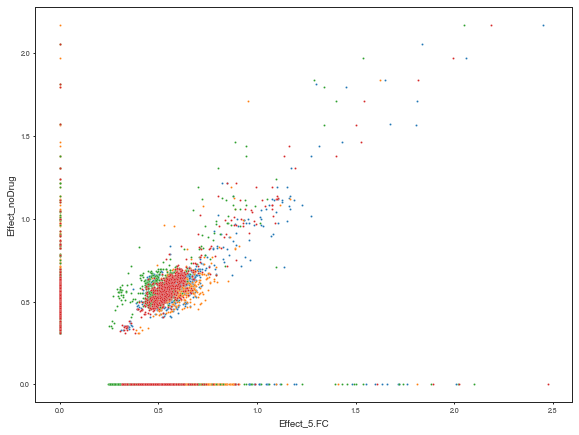

In [48]:
eQTL_vs_rMVP = pd.read_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')

SIGN_RES = eQTL_vs_rMVP[eQTL_vs_rMVP['-log_pval'] >= 3]
MTX_QTLs = SIGN_RES.groupby('SNP').sum()[np.abs(SIGN_RES.groupby('SNP').sum()['QTLs']) >= 155].reset_index()['SNP'].values
SIGN_RES = SIGN_RES[~SIGN_RES['SNP'].isin(MTX_QTLs)]

SIGN_RES['PPI'] = [ f"{SIGN_RES['Condition'][idx].split('_')[0]}:{SIGN_RES['Condition'][idx].split('_')[1]}" for idx in SIGN_RES.index ] 
SIGN_RES['DRUG'] = [ f"{SIGN_RES['Condition'][idx].split('_')[3]}" for idx in SIGN_RES.index ] 
SIGN_RES['CDT'] = [ f"{SIGN_RES['Condition'][idx].split('_')[2]}:{SIGN_RES['Condition'][idx].split('_')[3]}" for idx in SIGN_RES.index ] 

print(SIGN_RES.columns)
for DRUG in tqdm(['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']) : 
    print(DRUG)
    DRUG_vs_NODRUG = SIGN_RES[SIGN_RES['DRUG'] == DRUG][['SNP', 'PPI', 'Chr', 'Pos', 'Effect', '-log_pval', 'snps_class_up', 'snps_class_down', 'locus_id', 'name', 'sgd_id', 'description']].merge(SIGN_RES[SIGN_RES['DRUG'] == 'noDrug'][['SNP', 'PPI', 'Effect']], on=['SNP', 'PPI'], suffixes=[f'_{DRUG}', '_noDrug'], how='outer').reset_index(drop=True)
    DRUG_vs_NODRUG = DRUG_vs_NODRUG.replace(np.nan, 0)
    print(DRUG_vs_NODRUG.shape)
    
    sns.scatterplot(x=np.abs(DRUG_vs_NODRUG[f'Effect_{DRUG}']), y=np.abs(DRUG_vs_NODRUG['Effect_noDrug']))
    
    ES = (DRUG_vs_NODRUG[(DRUG_vs_NODRUG[f'Effect_{DRUG}'] == 0) | (DRUG_vs_NODRUG[f'Effect_noDrug'] == 0)])
    NES = (DRUG_vs_NODRUG[(DRUG_vs_NODRUG[f'Effect_{DRUG}'] != 0) & (DRUG_vs_NODRUG[f'Effect_noDrug'] != 0)])
    print(len(ES), len(NES))

    ES.reset_index(drop=True).sort_values(['locus_id', 'SNP', 'Chr', 'Pos', '-log_pval',], ascending=False).to_csv(f'../../results/05_piQTL_tables/ES_vs_NES/{DRUG}_ES_piQTLs.csv', index=False)
    NES.reset_index(drop=True).sort_values(['locus_id', 'SNP', 'Chr', 'Pos', '-log_pval'], ascending=False).to_csv(f'../../results/05_piQTL_tables/ES_vs_NES/{DRUG}_NES_piQTLs.csv', index=False)


____

## Effect distribution by genome annotations

In [5]:
# EFFECT_SIZE_DISTRIBUTION = eQTL_vs_rMVP
# MTX_QTLs = EFFECT_SIZE_DISTRIBUTION.groupby('SNP').sum()[np.abs(EFFECT_SIZE_DISTRIBUTION.groupby('SNP').sum()['QTLs']) >= 155].reset_index()['SNP'].values
# EFFECT_SIZE_DISTRIBUTION = EFFECT_SIZE_DISTRIBUTION[~EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs)]

# all_QTLs = EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['-log_pval'] >= 3 ] 
# print(len(all_QTLs))

# all_QTLs.to_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv', index=False)


all_QTLs = pd.read_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')

In [12]:
all_QTLs

,SNP,Condition,beta,t-stat,p-value_eQTL,FDR,Chr,Pos,Effect,SE,...,snps_class_down,description,genome_annotations,SNP_ID,-log_pval,QTLs,PPI,DRUG,CDT,h_2
0,4285,ERG11_MID2_MTX_Fluconazole,0.880617,7.464464,6.521361e-13,9.075840e-10,7,467332,0.880347,0.118293,...,Verified ORF,"""Member of the PUF protein family; PUF family ...",Verified ORF,CHR7_4285,12.117447,1,ERG11:MID2,Fluconazole,MTX:Fluconazole,0.135660
1,4286,ERG11_MID2_MTX_Fluconazole,0.877298,7.397772,1.008884e-12,1.379161e-09,7,467497,0.878984,0.118848,...,Verified ORF,"""Member of the PUF protein family; PUF family ...",Verified ORF,CHR7_4286,11.986293,1,ERG11:MID2,Fluconazole,MTX:Fluconazole,0.133569
2,4975,ERG11_PIS1_MTX_Fluconazole,0.879268,7.073718,8.081820e-12,1.012223e-08,8,122207,0.879268,0.124633,...,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,11.037061,1,ERG11:PIS1,Fluconazole,MTX:Fluconazole,0.123538
3,4976,ERG11_PIS1_MTX_Fluconazole,0.880947,7.065109,8.533412e-12,1.066281e-08,8,122347,0.881639,0.124991,...,SUT,ncRNA_UNB,Unstable transcript,CHR8_4976,11.033577,1,ERG11:PIS1,Fluconazole,MTX:Fluconazole,0.123274
4,4974,ERG11_PIS1_MTX_Fluconazole,0.881766,7.038621,1.008440e-11,1.254003e-08,8,122014,0.878482,0.125652,...,SUT,ncRNA_UNB,Unstable transcript,CHR8_4974,10.863838,1,ERG11:PIS1,Fluconazole,MTX:Fluconazole,0.122465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8893,10439,FMP45_MEP1_MTX_noDrug,-0.903190,-3.319090,9.967185e-04,2.356146e-01,15,448820,-0.897823,0.264409,...,Close to 3'-UTR,"""Cytochrome c1; component of the mitochondrial...",Verified ORF,CHR15_10439,3.117609,-1,FMP45:MEP1,noDrug,MTX:noDrug,0.030098
8894,4643,ERG11_ACF2_MTX_Metformin,-2.019611,-3.318787,9.977678e-04,2.357210e-01,7,876475,-2.017539,0.595014,...,Close to 3'-UTR,"""Chitin transglycosylase; functions in the tra...",Verified ORF,CHR7_4643,3.110170,-1,ERG11:ACF2,Metformin,MTX:Metformin,0.030093
8895,10195,HNM1_MAM33_MTX_Trifluoperazine,-0.549961,-3.318584,9.984717e-04,2.358114e-01,15,179652,-0.553965,0.165897,...,Verified ORF,"""GTPase-activating protein; negatively regulat...",Verified ORF,CHR15_10195,3.031585,-1,HNM1:MAM33,Trifluoperazine,MTX:Trifluoperazine,0.030089
8896,11944,HUG1_PGM2_MTX_Fluconazole,-0.550059,-3.318577,9.984928e-04,2.358114e-01,16,873212,-0.552435,0.166066,...,Verified ORF,"""Subunit of E3 ubiquitin ligase complex involv...",Verified ORF,CHR16_11944,3.012513,-1,HUG1:PGM2,Fluconazole,MTX:Fluconazole,0.030089


In [6]:
all_QTLs['h_2'] = np.square(all_QTLs['t-stat']) / (np.square(all_QTLs['t-stat']) + (357-2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 576x432 with 0 Axes>

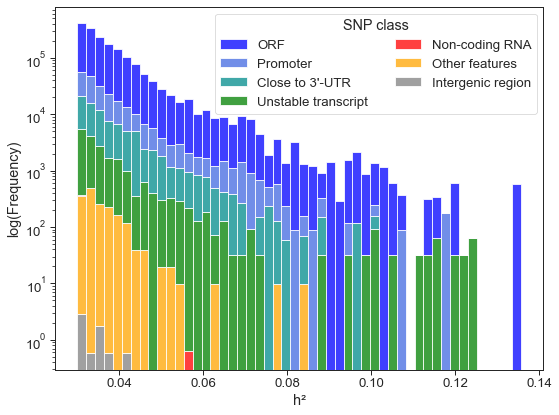

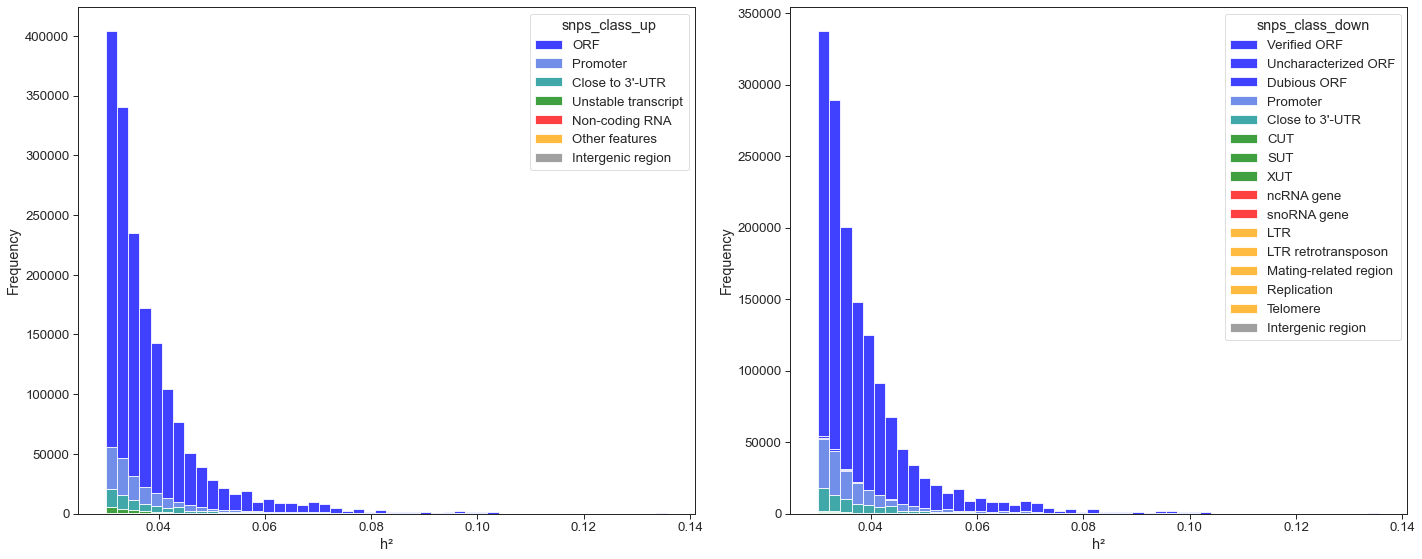

In [7]:
#### Figure 5A

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams.update({'font.size': 7})

snps_class_up = CategoricalDtype(
    ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'],
    ordered=True
)

snps_class_down = CategoricalDtype(
    ['Verified ORF', 
    'Uncharacterized ORF', 
    'Dubious ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'CUT',
    'SUT',
    'XUT',
    'ncRNA gene',
    'snoRNA gene',
    'LTR',
    'LTR retrotransposon',
    'Mating-related region',
    'Replication',  
    'Telomere',
    'Intergenic region'],
    ordered=True
)

all_QTLs['snps_class_up'] = all_QTLs['snps_class_up'].astype(snps_class_up)
all_QTLs['snps_class_down'] = all_QTLs['snps_class_down'].astype(snps_class_down)
sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks") 
sns.despine(offset=20)


e, ax = plt.subplots()
palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
sns.histplot(data=all_QTLs, x='h_2', hue='snps_class_up', stat='frequency', multiple="stack", palette=palette_snps_class_up, bins=50)
plt.yscale('log')
plt.xlabel('h²')
plt.ylabel('log(Frequency)')
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'], ncol=2, title='SNP class')
    
e.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av1b_no_MTX_peaks.png', format='png', dpi=300)
e.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av1b_no_MTX_peaks.eps', format='eps', dpi=300)

f, axes = plt.subplots(figsize=(20,8), ncols=2, nrows=1)
palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
sns.histplot(data=all_QTLs, x='h_2', hue='snps_class_up', stat='frequency', multiple="stack", palette=palette_snps_class_up, bins=50, ax=axes[0])
axes[0].set_xlabel('h²')
axes[0].set_ylabel('Frequency')
palette_snps_class_down=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey']
sns.histplot(data=all_QTLs, x='h_2', hue='snps_class_down', stat='frequency', multiple="stack", palette=palette_snps_class_down, bins=50, ax=axes[1])
axes[1].set_xlabel('h²')
axes[1].set_ylabel('Frequency')
plt.show()

# f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av2_no_MTX_peaks.png', format='png', dpi=300)
# f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av2_no_MTX_peaks.eps', format='eps', dpi=300)

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams.update({'font.size': 7})


snps_class_up = CategoricalDtype(
    ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'],
    ordered=True
)

snps_class_down = CategoricalDtype(
    ['Verified ORF', 
    'Uncharacterized ORF', 
    'Dubious ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'CUT',
    'SUT',
    'XUT',
    'ncRNA gene',
    'snoRNA gene',
    'LTR',
    'LTR retrotransposon',
    'Mating-related region',
    'Replication',  
    'Telomere',
    'Intergenic region'],
    ordered=True
)

all_QTLs['snps_class_up'] = all_QTLs['snps_class_up'].astype(snps_class_up)
all_QTLs['snps_class_down'] = all_QTLs['snps_class_down'].astype(snps_class_down)

f, axes = plt.subplots(figsize=(12,8), ncols=2, nrows=1)
palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
sns.jointplot(data=all_QTLs, x='h_2', y='snps_class_up', ratio=5, palette=palette_snps_class_up, ax=axes[0], marginal_kws=dict(bins=75), s=40)
axes[0].set_xlabel('h²')
axes[0].set_ylabel('SNP class (High Level)')
# legend = axes[0].get_legend()
# handles = legend.legendHandles
# legend.remove()
# palette_snps_class_down=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey']
sns.jointplot(data=all_QTLs, x='h_2', y='snps_class_down',  palette=palette_snps_class_down, ax=axes[1])
axes[1].set_xlabel('h²')
axes[1].set_ylabel('SNP class (Low Level)')
# plt.show()


In [ ]:
all_QTLs

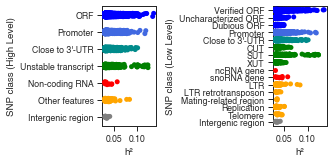

In [8]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

CM = 1/2.54 # centimeters in inches
SINGLE = 6 * CM
DOUBLE = 12 * CM

sns.set_context("paper", font_scale=1)

snps_class_up = CategoricalDtype(
    ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'],
    ordered=True
)

snps_class_down = CategoricalDtype(
    ['Verified ORF', 
    'Uncharacterized ORF', 
    'Dubious ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'CUT',
    'SUT',
    'XUT',
    'ncRNA gene',
    'snoRNA gene',
    'LTR',
    'LTR retrotransposon',
    'Mating-related region',
    'Replication',  
    'Telomere',
    'Intergenic region'],
    ordered=True
)

all_QTLs['snps_class_up'] = all_QTLs['snps_class_up'].astype(snps_class_up)
all_QTLs['snps_class_down'] = all_QTLs['snps_class_down'].astype(snps_class_down)

f, axes = plt.subplots(figsize=(DOUBLE, SINGLE), ncols=2, nrows=1)
palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
sns.stripplot(data=all_QTLs, x='h_2', y='snps_class_up', hue=all_QTLs['snps_class_up'], jitter=True, palette=palette_snps_class_up, ax=axes[0])
axes[0].set_xlabel('h²')
axes[0].set_ylabel('SNP class (High Level)')
legend = axes[0].get_legend()
handles = legend.legendHandles
legend.remove()
palette_snps_class_down=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey']
sns.stripplot(data=all_QTLs, x='h_2', y='snps_class_down', hue='snps_class_down', jitter=True, palette=palette_snps_class_down, ax=axes[1])
axes[1].set_xlabel('h²')
axes[1].set_ylabel('SNP class (Low Level)')
legend = axes[1].get_legend()
handles = legend.legendHandles
legend.remove()

plt.show()

f.tight_layout()

f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av1_no_MTX_peaks.png', format='png', dpi=300)
f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av1_no_MTX_peaks.eps', format='pdf', dpi=300)


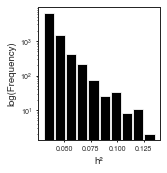

In [11]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 7
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 7
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

CM = 1/2.54 # centimeters in inches

# sns.set_context("paper", font_scale=0.5)

f = plt.figure(figsize=(6 * CM, 6 * CM))
plt.hist(all_QTLs['h_2'], bins=10, rwidth=0.9, log=True, color='black')
plt.xlabel('h²')
plt.ylabel('log(Frequency)')


f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av0_no_MTX_peaks.png', format='png', dpi=300)
f.savefig('../../manuscript/figures/FIGURE_5/FIGURE5Av0_no_MTX_peaks.eps', format='pdf', dpi=300)

In [ ]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

CM = 1/2.54 # centimeters in inches
SINGLE = 9 * CM
DOUBLE = 18 * CM

sns.set_context("paper")
sns.set_style("ticks") 
sns.despine(offset=20)

for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    TMP = all_QTLs[all_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)

    e, ax = plt.subplots(figsize=(DOUBLE, SINGLE))
    palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
    sns.stripplot(data=TMP, x='h_2', y='snps_class_up', hue='snps_class_up', jitter=True, palette=palette_snps_class_up)
    plt.xlabel('h²')
    plt.ylabel('SNP class')
    plt.title(DRUG)
    legend = ax.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax.legend(handles, ['ORF', 
        'Promoter', 
        "Close to 3'-UTR", 
        'Unstable transcript',
        'Non-coding RNA', 
        'Other features',  
        'Intergenic region'], title='SNP class', bbox_to_anchor=(1.04, 1), loc="upper left")

    e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv1_{DRUG}_no_MTX_peaks.png', format='png', dpi=300)
    e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv1_{DRUG}_no_MTX_peaks.eps', format='eps', dpi=300)


In [ ]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

CM = 1/2.54 # centimeters in inches
SINGLE = 9 * CM
DOUBLE = 18 * CM

sns.set_context("paper", font_scale=1)
sns.set_style("ticks") 
sns.despine(offset=20)

for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    TMP = all_QTLs[all_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)

    e, ax = plt.subplots(figsize=(DOUBLE, SINGLE))
    palette_snps_class_down=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey']
    sns.stripplot(data=TMP, x='h_2', y='snps_class_down', hue='snps_class_down', jitter=True, palette=palette_snps_class_down)
    plt.xlabel('h²')
    plt.ylabel('SNP class')
    plt.title(DRUG)
    legend = ax.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax.legend(handles, ['ORF', 
        'Promoter', 
        "Close to 3'-UTR", 
        'Unstable transcript',
        'Non-coding RNA', 
        'Other features',  
        'Intergenic region'], title='SNP class', bbox_to_anchor=(1.04, 1), loc="upper left")

    e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv2_{DRUG}_no_MTX_peaks.png', format='png', dpi=300)
    e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv2_{DRUG}_no_MTX_peaks.eps', format='eps', dpi=300)


In [ ]:
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams.update({'font.size': 7})

for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine']:
    TMP = all_QTLs[all_QTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)

    sns.set_context("paper", font_scale=1.5)
    sns.set_style("ticks") 
    sns.despine(offset=20)
s
    e, ax = plt.subplots()
    palette_snps_class_up = ['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey']
    sns.histplot(data=TMP, x='h_2', hue='snps_class_up', stat='frequency', multiple="stack", palette=palette_snps_class_up, bins=50)
    plt.yscale('log')
    plt.xlabel('h²')
    plt.ylabel('log(Frequency)')
    plt.title(DRUG)
    legend = ax.get_legend()
    handles = legend.legendHandles
    legend.remove()
    ax.legend(handles, ['ORF', 
        'Promoter', 
        "Close to 3'-UTR", 
        'Unstable transcript',
        'Non-coding RNA', 
        'Other features',  
        'Intergenic region'], title='SNP class', bbox_to_anchor=(1.04, 1), loc="upper left")
    # e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv2_{DRUG}_no_MTX_peaks.png', format='png', dpi=300)
    # e.savefig(f'../../manuscript/figures/FIGURE_5/FIGURE5Cv2_{DRUG}_no_MTX_peaks.eps', format='eps', dpi=300)

In [ ]:
snps_class_up = CategoricalDtype(
    ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'],
    ordered=True
)

snps_class_down = CategoricalDtype(
    ['Verified ORF', 
    'Uncharacterized ORF', 
    'Dubious ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'CUT',
    'SUT',
    'XUT',
    'ncRNA gene',
    'snoRNA gene',
    'LTR',
    'LTR retrotransposon',
    'Mating-related region',
    'Replication',  
    'Telomere',
    'Intergenic region'],
    ordered=True
)

plt.rcParams["figure.figsize"] = [25, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams.update({'font.size': 7})

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks") 
sns.despine(offset=20)
f, axes = plt.subplots(ncols=2, sharex=True)
EFFECT_SIZE_DISTRIBUTION['snps_class_up'] = EFFECT_SIZE_DISTRIBUTION['snps_class_up'].astype(snps_class_up)
EFFECT_SIZE_DISTRIBUTION['snps_class_down'] = EFFECT_SIZE_DISTRIBUTION['snps_class_down'].astype(snps_class_down)
EFFECT_SIZE_DISTRIBUTION['Effect'] = np.abs(EFFECT_SIZE_DISTRIBUTION['Effect'])
all_QTLs = EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['-log_pval'] >= 3 ] 
print(len(all_QTLs))

sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_up'], palette=['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey'], ax=axes[0])
axes[0].set_ylabel('Genome localization of piQTLs')
axes[0].set_xlabel('Effect size (absolute value)')
axes[0].set_title('SNP Class (high level)')
sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_down'], palette=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey'], ax=axes[1])
axes[1].set_ylabel('Genome localization of piQTLs')
axes[1].set_xlabel('Effect size (absolute value)')
axes[1].set_title('SNP class (low level)')


plt.show()


f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_no_MTX_peaks.png', format='png', dpi=300)
f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_no_MTX_peaks.eps', format='pdf', dpi=300)

In [ ]:
EFFECT_SIZE_DISTRIBUTION = eQTL_vs_rMVP
MTX_QTLs = EFFECT_SIZE_DISTRIBUTION.groupby('SNP').sum()[np.abs(EFFECT_SIZE_DISTRIBUTION.groupby('SNP').sum()['QTLs']) >= 155].reset_index()['SNP'].values
# EFFECT_SIZE_DISTRIBUTION = EFFECT_SIZE_DISTRIBUTION[~EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs)]
EFFECT_SIZE_DISTRIBUTION = EFFECT_SIZE_DISTRIBUTION[~EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs) & ~(EFFECT_SIZE_DISTRIBUTION['SNP'].isin(TO_REMOVE))]

all_QTLs = EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['-log_pval'] >= 3 ] 
print(len(all_QTLs))
all_QTLs.to_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_and_noDrug_peaks.csv', index=False)

In [ ]:
snps_class_up = CategoricalDtype(
    ['ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'Unstable transcript',
    'Non-coding RNA', 
    'Other features',  
    'Intergenic region'],
    ordered=True
)

snps_class_down = CategoricalDtype(
    ['Verified ORF', 
    'Uncharacterized ORF', 
    'Dubious ORF', 
    'Promoter', 
    "Close to 3'-UTR", 
    'CUT',
    'SUT',
    'XUT',
    'ncRNA gene',
    'snoRNA gene',
    'LTR',
    'LTR retrotransposon',
    'Replication',  
    'Telomere',
    'Intergenic region'],
    ordered=True
)

plt.rcParams["figure.figsize"] = [25, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams.update({'font.size': 7})

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks") 
sns.despine(offset=20)
f, axes = plt.subplots(ncols=2, sharex=True)
EFFECT_SIZE_DISTRIBUTION['snps_class_up'] = EFFECT_SIZE_DISTRIBUTION['snps_class_up'].astype(snps_class_up)
EFFECT_SIZE_DISTRIBUTION['snps_class_down'] = EFFECT_SIZE_DISTRIBUTION['snps_class_down'].astype(snps_class_down)
EFFECT_SIZE_DISTRIBUTION['Effect'] = np.abs(EFFECT_SIZE_DISTRIBUTION['Effect'])
all_QTLs = EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['-log_pval'] >= 3 ] 
print(len(all_QTLs))
sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_up'], palette=['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey'], ax=axes[0])
axes[0].set_ylabel('Genome localization of piQTLs')
axes[0].set_xlabel('Effect size (absolute value)')
axes[0].set_title('SNP Class (high level)')
sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_down'], palette=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'grey'], ax=axes[1])
axes[1].set_ylabel('Genome localization of piQTLs')
axes[1].set_xlabel('Effect size (absolute value)')
axes[1].set_title('SNP class (low level)')


plt.show()


f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_no_MTX_noDrug_peaks.png', format='png', dpi=300)
f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_no_MTX_noDrug_peaks.pdf', format='pdf', dpi=300)

 

### Save MTX-specific / noDrug-specific QTLs

In [ ]:
len(np.unique(MTX_QTLs))

In [ ]:
len(np.unique(TO_REMOVE))

In [ ]:
EFFECT_SIZE_DISTRIBUTION = eQTL_vs_rMVP
EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs)].drop_duplicates(subset="SNP", keep='first')[['SNP', 'Chr', 'Pos', 'locus_id', 'name', 'p-value_eQTL', 'p-value_rMVP', 'FDR','-log_pval', 'Effect', 'snps_class_up', 'snps_class_down', 'description']].reset_index(drop=True)
EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs)].drop_duplicates(subset="SNP", keep='first')[['SNP', 'Chr', 'Pos', 'locus_id', 'name', 'p-value_eQTL', 'p-value_rMVP', 'FDR', '-log_pval', 'Effect', 'snps_class_up', 'snps_class_down', 'description']].reset_index(drop=True).sort_values(['FDR', 'SNP', 'Chr', 'Pos',]).to_csv('../../results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv', index=False)

In [ ]:
EFFECT_SIZE_DISTRIBUTION = eQTL_vs_rMVP
EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['SNP'].isin(TO_REMOVE)].drop_duplicates(subset="SNP", keep='first')[['SNP', 'Chr', 'Pos', 'locus_id', 'name',  'p-value_eQTL', 'p-value_rMVP', 'FDR', '-log_pval', 'Effect', 'snps_class_up', 'snps_class_down', 'description']].reset_index(drop=True)
EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['SNP'].isin(TO_REMOVE)].drop_duplicates(subset="SNP", keep='first')[['SNP', 'Chr', 'Pos', 'locus_id', 'name',  'p-value_eQTL', 'p-value_rMVP', 'FDR', '-log_pval', 'Effect', 'snps_class_up', 'snps_class_down', 'description']].reset_index(drop=True).sort_values(['FDR', 'SNP', 'Chr', 'Pos',]).to_csv('../../results/05_piQTL_tables/noDrug_specific_QTLs_with_genome_annotations.csv', index=False)

### Stripplot

In [23]:
phenotype = pd.read_csv('../../results/03_ppi_estimation/logratio/all_PPI_logratio_fitness_before_downsampling_minus_ref_for_rMVP.csv')
cols = list(genotype.columns)
cols.remove('snp_id')
phenotype = phenotype.set_index('TAXA').T[cols].reset_index().rename(columns={'index':'condition'})

In [66]:
CM = 1/2.54 # centimeters in inches


import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.size"] = 5
mpl.rcParams["axes.titlesize"] = 6
mpl.rcParams["xtick.labelsize"] = 7
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["xtick.minor.size"] = 1.2
mpl.rcParams["ytick.labelsize"] = 7
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["ytick.minor.size"] = 1.2
mpl.rcParams["lines.linewidth"] = 1.2
mpl.rcParams["lines.markersize"] = 2
mpl.rcParams["lines.markeredgewidth"] = 0.5
mpl.rcParams["boxplot.flierprops.markersize"] = 2
mpl.rcParams["boxplot.flierprops.markeredgewidth"] = 0.5
mpl.rcParams["legend.fontsize"] = 5

def create_striplot_input(snp_id, phenotype_id, locus):
    ind_list = list(genotype.columns)[1:]
    genotype_list = list(genotype[ genotype['snp_id'] == snp_id ].values[0])[1:]
    phenotype_list = list(phenotype[ phenotype['condition'].str.contains(phenotype_id) ].values[0])[1:]

    tmp = []
    for i in range(len(ind_list)):
        tmp.append([ind_list[i], genotype_list[i], phenotype_list[i]])

    table = pd.DataFrame(tmp, columns=['strain_id', 'genotype', 'fitness'])
    table.to_csv(f'./{snp_id}_{phenotype_id}_{locus}.csv', index=False)
    print(table.groupby('genotype').count())

    f = plt.figure(figsize=(8*CM,8*CM))
    sns.stripplot(x="genotype", y="fitness", data=table, marker='.', color='grey')
    ### For SUT153
    sns.boxplot(x="genotype", y="fitness", data=table, color='white')
    sns.stripplot(x="genotype", y="fitness", data=table[table['strain_id'].isin(['731', '1016', '1038', '521', '60', '841', '983', '589', '690', '842'])], marker='.', hue='genotype', palette=['orange', 'cyan'])
    strains_of_interest = table[table['strain_id'].isin(['731', '1016', '1038', '521', '60', '841', '983', '589', '690', '842'])].reset_index(drop=True)
    print(strains_of_interest)
    texts = []
    for idx in strains_of_interest.index : 
        strain = strains_of_interest['strain_id'][idx]
        x = strains_of_interest['genotype'][idx]
        if x == -1 :
            x = 0
        y = strains_of_interest['fitness'][idx]
        # plt.annotate(strain, (x,y), xytext=(x+0.05,y+0.05) , xycoords='data')
        texts.append(plt.text(x, y, strain))

    adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1))
        
    plt.ylabel('Fitness')
    plt.xlabel('Genotype')
    plt.legend('')
    print(stats.ttest_ind(table['genotype'], table['fitness']))
    plt.title(f'SNP {snp_id}')

    f.savefig(f'./{snp_id}_stripplot_annotated_strains.png', dpi=300)
    f.savefig(f'./{snp_id}_stripplot_annotated_strains.eps', dpi=300)

##### Phenotype vs. Genotype (Fluconazole) - SUT153

          strain_id  fitness
genotype                    
-1              210      210
 1              147      147
  strain_id  genotype    fitness
0        60        -1   1.933189
1       521        -1   3.583242
2       589         1  11.989074
3       690         1   9.700696
4       731        -1   7.045786
5       841         1  13.088001
6       842         1  10.285802
7       983         1  12.100666
8      1016        -1   5.079819
9      1038        -1   1.741100
Ttest_indResult(statistic=-57.644940283924434, pvalue=2.1012825079681506e-270)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


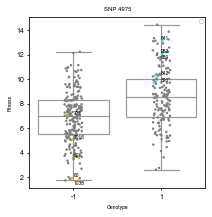

In [67]:
create_striplot_input(4975, 'ERG11_MID2_MTX_Fluconazole', 'SUT153')

In [ ]:
create_striplot_input(4976, 'ERG11_PIS1_MTX_Fluconazole', 'SUT153')

##### Phenotype vs. Genotype (Metformin) - GWAS Diabetes type II

,strain_id,genotype,fitness
0,6,-1,6.158700
1,7,-1,6.723762
2,14,1,8.578192
3,15,-1,7.598656
4,17,-1,6.597272
...,...,...,...
352,1065,-1,5.512310
353,1069,-1,7.901855
354,17_2,-1,5.851345
355,40_2,-1,5.143827


          strain_id  fitness
genotype                    
-1              164      164
 1              193      193
Ttest_indResult(statistic=-61.112040097143826, pvalue=1.974141011362927e-285)


<Figure size 432x288 with 0 Axes>

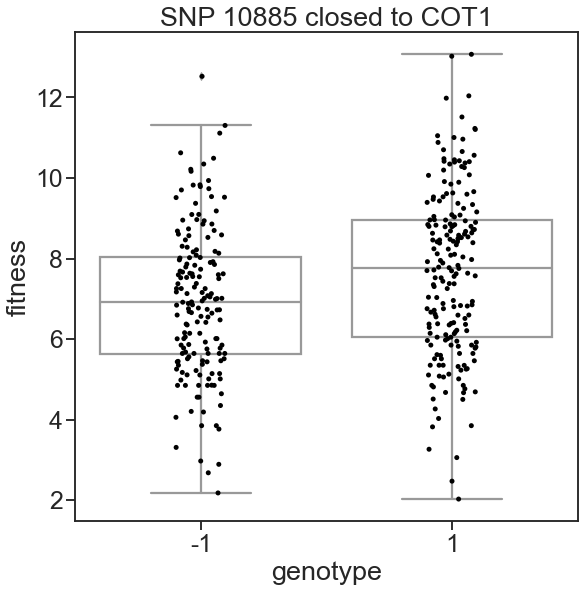

In [5]:
create_striplot_input(10885, 'ERG11_ERV25_MTX_Metformin', 'COT1')

,strain_id,genotype,fitness
0,6,1,7.256708
1,7,1,5.763637
2,14,-1,5.139778
3,15,1,6.473575
4,17,-1,5.056742
...,...,...,...
352,1065,1,7.310243
353,1069,-1,7.062588
354,17_2,-1,3.895778
355,40_2,-1,5.188259


          strain_id  fitness
genotype                    
-1              171      171
 0                1        1
 1              185      185
Ttest_indResult(statistic=-36.61481309317606, pvalue=7.360522886738099e-166)


<Figure size 432x288 with 0 Axes>

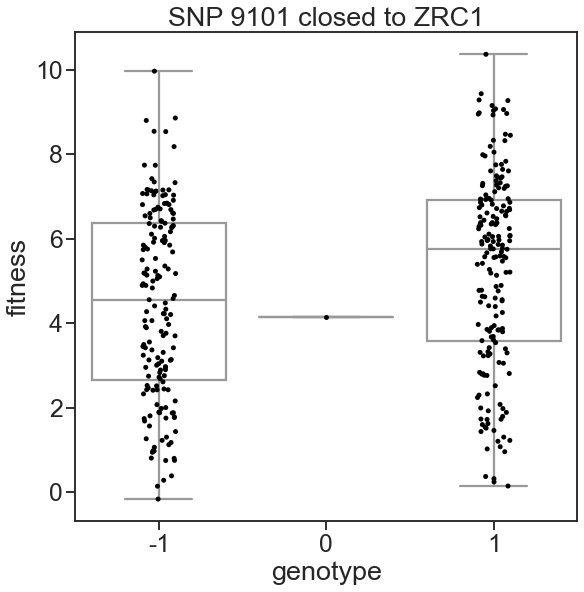

In [6]:
create_striplot_input(9101, 'SNA4_GTR2_MTX_Metformin', 'ZRC1')

,strain_id,genotype,fitness
0,6,1,7.365321
1,7,1,9.800503
2,14,1,8.642928
3,15,-1,9.702003
4,17,1,5.950283
...,...,...,...
352,1065,1,8.872644
353,1069,-1,11.858793
354,17_2,1,6.950283
355,40_2,-1,6.628355


          strain_id  fitness
genotype                    
-1              180      180
 0                7        7
 1              170      170
Ttest_indResult(statistic=-52.026610867241104, pvalue=8.940783893749277e-245)


<Figure size 432x288 with 0 Axes>

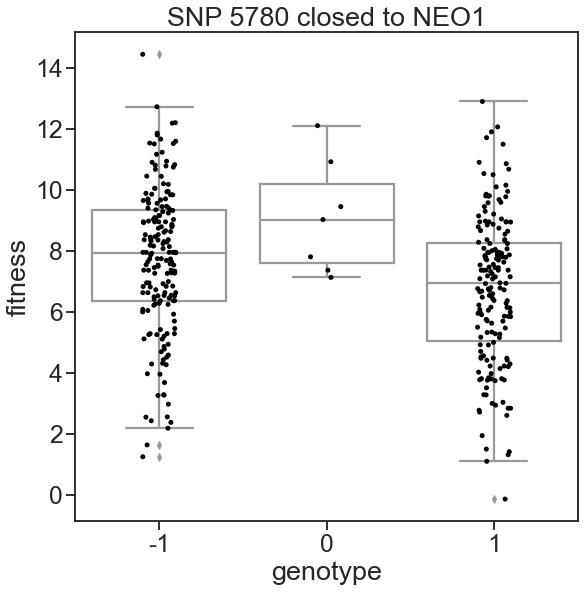

In [7]:
create_striplot_input(5780, 'ALO1_ADE17_MTX_Metformin', 'NEO1')

_____

### Effect size distribution with MTX and NoDrug QTLs

In [ ]:
EFFECT_SIZE_DISTRIBUTION = pd.concat(all_MTX).reset_index(drop=True)
#  EFFECT_SIZE_DISTRIBUTION = EFFECT_SIZE_DISTRIBUTION[~EFFECT_SIZE_DISTRIBUTION['SNP'].isin(MTX_QTLs)]
       
EFFECT_SIZE_DISTRIBUTION['Effect'] = np.abs(EFFECT_SIZE_DISTRIBUTION['Effect'])

sns.set_context("talk", font_scale=1)
sns.set_style("ticks") 
sns.despine(offset=20)
f, axes = plt.subplots(figsize=(36,9), ncols=2, sharex=True)
EFFECT_SIZE_DISTRIBUTION['snps_class_up'] = EFFECT_SIZE_DISTRIBUTION['snps_class_up'].astype(snps_class_up)
EFFECT_SIZE_DISTRIBUTION['snps_class_down'] = EFFECT_SIZE_DISTRIBUTION['snps_class_down'].astype(snps_class_down)
all_QTLs = EFFECT_SIZE_DISTRIBUTION[EFFECT_SIZE_DISTRIBUTION['-log_pval'] >= 3 ] 

sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_up'], palette=['blue', 'royalblue', 'darkcyan', 'green', 'red', 'orange', 'grey'], ax=axes[0])
axes[0].set_ylabel('Genome localization of piQTLs')
axes[0].set_xlabel('Effect size (absolute value)')
axes[0].set_title('SNP Class (high level)')
sns.boxplot(x=all_QTLs['Effect'], y=all_QTLs['snps_class_down'], palette=['blue', 'blue', 'blue', 'royalblue', 'darkcyan', 'green', 'green', 'green', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'grey'], ax=axes[1])
axes[1].set_ylabel('Genome localization of piQTLs')
axes[1].set_xlabel('Effect size (absolute value)')
axes[1].set_title('SNP class (low level)')

# f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_all_peaks.png', format='png', dpi=300)
# f.savefig('../../manuscript/figures/FIGURE_2/FIGURE2A_all_peaks.pdf', format='pdf', dpi=300)

# EFFECT_SIZE_DISTRIBUTION.to_csv('../../results/05_piQTL_tables/all_piQTLs_results_with_genome_annotations_with_MTX_peaks.csv', index=False)
# all_QTLs.to_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_with_MTX_peaks.csv', index=False)